## Plot gene set comparison

In this notebook, we want to compare prediction of mutations in the genes from our cancer gene set, derived from [Vogelstein et al. 2013](https://science.sciencemag.org/content/339/6127/1546), with two other sets of potentially relevant genes. These are:

* The most frequently mutated genes in TCGA
* A set of random genes in TCGA, that meet our mutation count threshold for 2 or more cancer types
 
We selected enough genes in each of these gene sets to match the count of the Vogelstein et al. gene set.
 
In these experiments we only used gene expression data, and we used the set of TCGA samples that have both gene expression and MC3 somatic mutation data. The files analyzed in this notebook were generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)
* PLOT_AUROC (bool): if True plot AUROC, else plot AUPR

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# if True, plot results for merged geneset (see 00_download_data/2_download_cancer_gene_data.ipynb)
# if False, plot results for Vogelstein et al. 2013 gene set
merged_geneset = True

if merged_geneset:
    cancer_genes_results_dir = Path(cfg.results_dirs['mutation'],
                                    'merged_expression',
                                    'gene').resolve()
    top_50_results_dir = Path(cfg.results_dirs['mutation'],
                              'expression_top',
                              'gene').resolve()
    random_50_results_dir = Path(cfg.results_dirs['mutation'],
                                 'expression_random',
                                 'gene').resolve()
else:
    cancer_genes_results_dir = Path(cfg.results_dirs['mutation'],
                                    'shuffle_cancer_type',
                                    'expression_vogelstein',
                                    'gene').resolve()
    top_50_results_dir = Path(cfg.results_dirs['mutation'],
                              'shuffle_cancer_type',
                              'expression_top',
                              'gene').resolve()
    random_50_results_dir = Path(cfg.results_dirs['mutation'],
                                 'shuffle_cancer_type',
                                 'expression_random',
                                 'gene').resolve()
    
# if True, save figures to the directory specified in images_dir below
SAVE_FIGS = True

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, plot AUROC instead of AUPR
PLOT_AUROC = False
if PLOT_AUROC:
    plot_metric = 'auroc'
    images_dir = Path(cfg.images_dirs['mutation'], 'auroc')
else:
    plot_metric = 'aupr'
    images_dir = Path(cfg.images_dirs['mutation'])

In [3]:
# load raw data
cancer_genes_df = au.load_stratified_prediction_results(cancer_genes_results_dir, 'gene')
cancer_genes_df = cancer_genes_df[cancer_genes_df.training_data.isin(['expression'])]
cancer_genes_df['gene_set'] = 'cancer_genes'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(cancer_genes_df.shape)
print(cancer_genes_df.seed.unique())
print(cancer_genes_df.training_data.unique())
cancer_genes_df.head()

(12840, 10)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.99984,0.99847,MAP3K1,expression,signal,42,train,0,gene,cancer_genes
1,0.75316,0.44403,MAP3K1,expression,signal,42,test,0,gene,cancer_genes
2,0.67811,0.30395,MAP3K1,expression,signal,42,cv,0,gene,cancer_genes
3,0.99946,0.99429,MAP3K1,expression,signal,42,train,1,gene,cancer_genes
4,0.67230,0.42410,MAP3K1,expression,signal,42,test,1,gene,cancer_genes


In [4]:
# load raw data
top_50_df = au.load_stratified_prediction_results(top_50_results_dir, 'gene')
top_50_df = top_50_df[top_50_df.training_data.isin(['expression'])]
top_50_df['gene_set'] = 'top_50'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(top_50_df.shape)
print(top_50_df.seed.unique())
print(top_50_df.training_data.unique())
top_50_df.head()

(12864, 10)
[ 1 42]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.70121,0.22698,MYH1,expression,signal,1,train,0,gene,top_50
1,0.65612,0.24894,MYH1,expression,signal,1,test,0,gene,top_50
2,0.57270,0.17408,MYH1,expression,signal,1,cv,0,gene,top_50
3,0.99817,0.98610,MYH1,expression,signal,1,train,1,gene,top_50
4,0.53171,0.15034,MYH1,expression,signal,1,test,1,gene,top_50


In [5]:
# load raw data
random_50_df = au.load_stratified_prediction_results(random_50_results_dir, 'gene')
random_50_df = random_50_df[random_50_df.training_data.isin(['expression'])]
random_50_df['gene_set'] = 'random_50'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(random_50_df.shape)
print(random_50_df.seed.unique())
print(random_50_df.training_data.unique())
random_50_df.head()

(12744, 10)
[ 1 42]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,1.00000,1.000000,NLRP1,expression,signal,1,train,0,gene,random_50
1,0.52787,0.110810,NLRP1,expression,signal,1,test,0,gene,random_50
2,0.48421,0.155010,NLRP1,expression,signal,1,cv,0,gene,random_50
3,0.50000,0.081633,NLRP1,expression,signal,1,train,1,gene,random_50
4,0.50000,0.046154,NLRP1,expression,signal,1,test,1,gene,random_50


In [6]:
# combine results dataframes
results_df = (
    pd.concat((cancer_genes_df, top_50_df, random_50_df))
      .drop(columns=['training_data', 'experiment'])
      .rename(columns={'gene_set': 'training_data'})
)

all_results_df = au.compare_all_data_types(results_df,
                                           SIG_ALPHA,
                                           filter_genes=False,
                                           metric=plot_metric)

all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)
all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
69,EGFR,0.573643,2.610929e-10,6.997289e-08,True,cancer_genes,7.155070
59,CTNNB1,0.529456,1.810615e-09,2.426224e-07,True,cancer_genes,6.615069
50,CTNNB1,0.529456,1.810615e-09,4.852448e-07,True,top_50,6.314039
58,CTNNB1,0.529456,1.810615e-09,4.852448e-07,True,random_50,6.314039
149,MAP3K1,0.324508,4.458255e-09,3.982708e-07,True,cancer_genes,6.399822
73,ERBB2,0.579440,6.484689e-09,4.019132e-07,True,cancer_genes,6.395868
38,CCND1,0.597130,7.779001e-09,4.019132e-07,True,cancer_genes,6.395868
31,CCND1,0.597130,7.779001e-09,1.042386e-06,True,random_50,5.981971
49,CDKN2A,0.268761,8.998057e-09,4.019132e-07,True,cancer_genes,6.395868
33,CDKN2A,0.268761,8.998057e-09,1.071390e-06,True,top_50,5.970052


random: 14/268 (overlap 13/14)
most mutated: 80/268 (overlap 26/80)
cancer gene set: 120/268 (overlap 36/120)


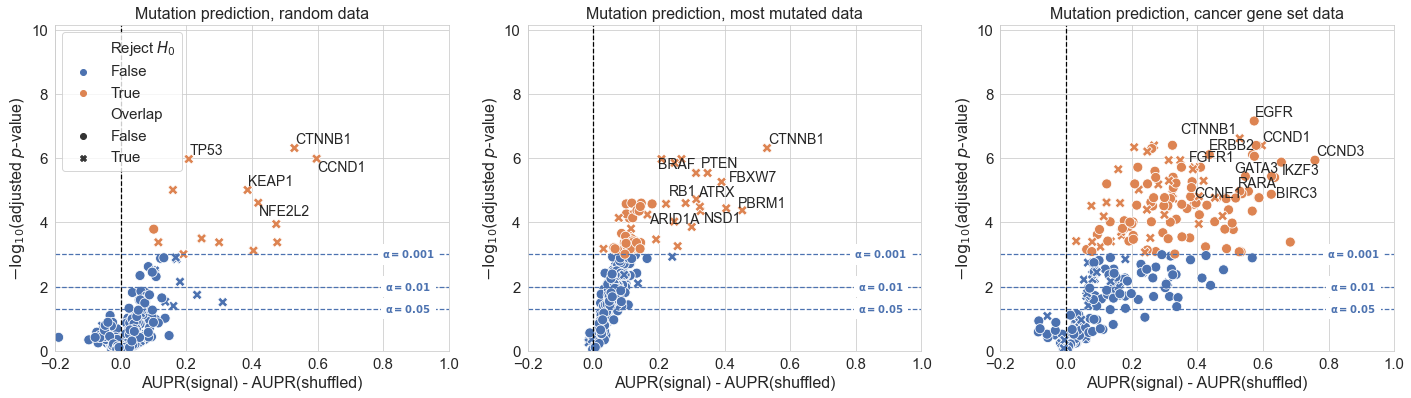

In [13]:
sns.set({'figure.figsize': (24, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

gene_set_map = {
    'random_50': 'random',
    'top_50': 'most mutated',
    'cancer_genes': 'cancer gene set'
}
all_results_df.training_data.replace(to_replace=gene_set_map, inplace=True)

# labeling lower bounds are chosen to show only key genes (well-performing,
# i.e. up and to the right) otherwise labels will overlap and be unreadable
plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          gene_set_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True,
                          label_x_lower_bounds=[0.2, 0.3, 0.5],
                          label_y_lower_bounds=[4, 4, 5],
                          mark_overlap=True,
                          overlap_reference='cancer gene set')

if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'expression_vs_shuffled.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'expression_vs_shuffled.png',
                dpi=300, bbox_inches='tight')

cancer gene set: 120/268


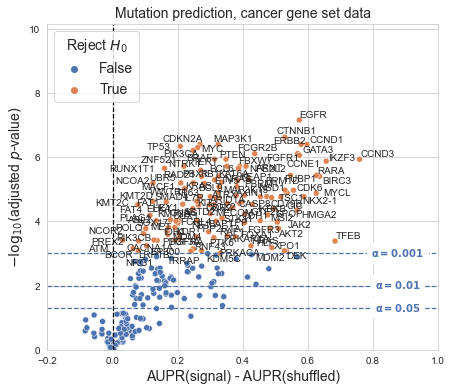

In [8]:
sns.set({'figure.figsize': (7, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 1)

gene_set_map = {
    'cancer_genes': 'cancer gene set'
}
all_results_df.training_data.replace(to_replace=gene_set_map, inplace=True)

plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          gene_set_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True)

if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'expression_cancer_genes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'expression_cancer_genes.png',
                dpi=300, bbox_inches='tight')

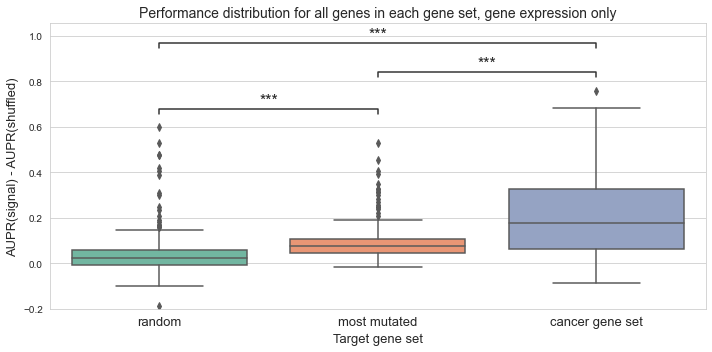

In [9]:
sns.set({'figure.figsize': (10, 5)})
sns.set_style('whitegrid')
# we want these colors to be different than the expression/methylation ones
sns.set_palette('Set2')
fig, axarr = plt.subplots(1, 1)


gene_set_map = {
    'random_50': 'random',
    'top_50': 'most mutated',
    'cancer_genes': 'cancer gene set'
}

all_results_df = (all_results_df
   .rename(columns={'training_data': 'gene_set'})
   .sort_values(by='gene_set', ascending=False)
)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr
sns.boxplot(data=all_results_df, x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Performance distribution for all genes in each gene set, gene expression only', size=14)
ax.set_xlabel('Target gene set', size=13)
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()),
              size=13)
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))
for tick in ax.get_xticklabels():
    tick.set_fontsize(13)
    
plt.tight_layout()

tests_df = plu.add_annotation(ax,
                              all_results_df.rename(
                                  columns={'gene_set': 'training_data'}
                              ),
                              all_pairs=(gene_set_map.values()),
                              metric=plot_metric,
                              box_pairs=[('random', 'most mutated'),
                                         ('most mutated', 'cancer gene set'),
                                         ('random', 'cancer gene set')])

if SAVE_FIGS:
    plt.savefig(images_dir / 'expression_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'expression_boxes.png',
                dpi=300, bbox_inches='tight')

In [10]:
# pairwise rank sum tests comparing results distributions
# H0: results distributions are the same between the data types
if not merged_geneset:
    tests_df.sort_values('p_value')

(174,)
['FAT4' 'FOXA1' 'KMT2B' 'KEAP1' 'IDH1' 'DNAH11' 'AXIN1' 'CCND1' 'CTNNB1'
 'SPOP' 'SETD2' 'RUNX1T1' 'TP53' 'NFE2L2' 'PREX2' 'PLEC' 'PIK3CA' 'PEG3'
 'PDE4DIP' 'PTEN' 'RB1' 'RELN' 'RNF213' 'RYR2' 'MUC16' 'MUC17' 'MUC5B'
 'MXRA5' 'MYH8' 'PBRM1' 'NBEA' 'NEB' 'NF1' 'NSD1' 'RYR1' 'TTN' 'UNC79'
 'USH2A' 'UTRN' 'VPS13B' 'XIRP2' 'XIST' 'ZFHX4' 'ZNF536' 'SI' 'SYNE1'
 'TENM1' 'TG' 'COL22A1' 'CSMD1' 'CSMD3' 'CDKN2A' 'DCHS2' 'DNAH10' 'APOB'
 'ADAMTS12' 'AHNAK2' 'ARID1A' 'CACNA1E' 'ATM' 'ATRX' 'BAGE2' 'BRAF'
 'DNAH8' 'HUWE1' 'HRNR' 'HMCN1' 'HERC2' 'HECTD4' 'KMT2C' 'KMT2D' 'KRAS'
 'LAMA2' 'LRP1' 'LRP1B' 'LRP2' 'MACF1' 'DOCK3' 'GPR98' 'FAT3' 'DST'
 'EP300' 'FAT1' 'FRAS1' 'FLG' 'FCGBP' 'FBXW7' 'FCGR2B' 'FCRL4' 'FGFR1'
 'FGFR3' 'ETV5' 'ERBB2' 'ELK4' 'EGFR' 'HRAS' 'KDM5C' 'KAT6A' 'JAK2' 'IL7R'
 'IKZF3' 'IKBKB' 'HMGA2' 'HLF' 'HEY1' 'H3F3A' 'GTF2I' 'GNAS' 'GATA3'
 'FUBP1' 'BIRC3' 'BCOR' 'BCL9' 'BCL6' 'BAP1' 'CACNA1A' 'ARNT' 'AKT2' 'DEK'
 'DDR2' 'CUX1' 'CIC' 'CDK6' 'CDH1' 'CD79B' 'CCNE1' 'CCND3' 'CASP

(-0.2, 0.808721875)

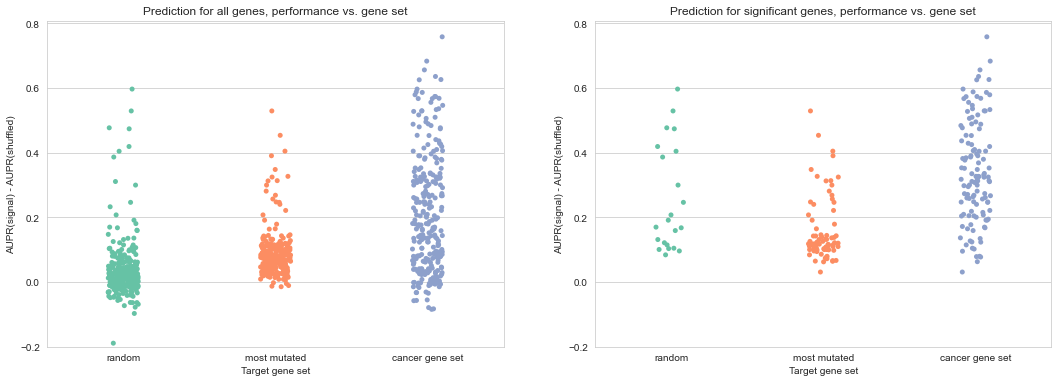

In [11]:
sns.set({'figure.figsize': (18, 6)})
sns.set_style('whitegrid')
# we want these colors to be different than the expression/methylation ones
sns.set_palette('Set2')
fig, axarr = plt.subplots(1, 2)

all_results_df.replace({'gene_set': gene_set_map}, inplace=True)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0]
sns.stripplot(data=all_results_df, x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Prediction for all genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

# plot mean performance for genes that are significant for at least one data type
ax = axarr[1]
gene_list = all_results_df[all_results_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.stripplot(data=all_results_df[all_results_df.gene.isin(gene_list)],
              x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Prediction for significant genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('{}(signal) - {}(shuffled)'.format(
                  plot_metric.upper(), plot_metric.upper()))
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

### Calculate gene set overlap
 
Of the significantly predictable genes in the top/random gene sets, how many of them are in the Vogelstein gene set?

random 268
most mutated 268
cancer gene set 268


Text(0.5, 1.0, 'Gene overlap between all genes in gene set')

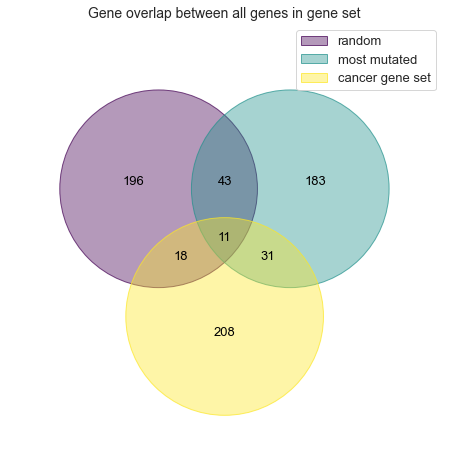

In [12]:
from venn import venn

# first look at overlap of all genes
genes_in_gene_set = {}
for gene_set in all_results_df.gene_set.unique():
    gene_list = all_results_df[all_results_df.gene_set == gene_set].gene.unique()
    print(gene_set, len(gene_list))
    genes_in_gene_set[gene_set] = set(gene_list)

venn(genes_in_gene_set)
plt.title('Gene overlap between all genes in gene set', size=14)

random 14
most mutated 80
cancer gene set 120


Text(0.5, 1.0, 'Gene overlap between significantly predictable genes in gene set')

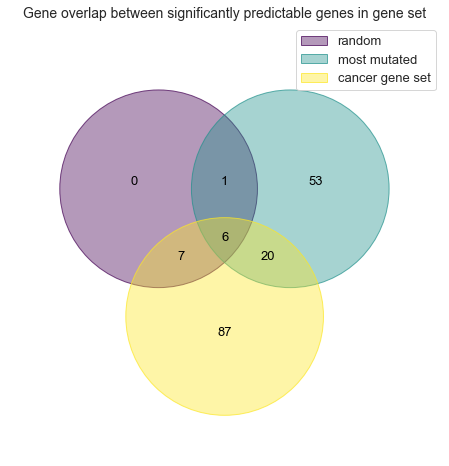

In [13]:
# now look at overlap of significant genes
genes_in_gene_set = {}
for gene_set in all_results_df.gene_set.unique():
    gene_list = all_results_df[(all_results_df.gene_set == gene_set) &
                               (all_results_df.reject_null)].gene.unique()
    print(gene_set, len(gene_list))
    genes_in_gene_set[gene_set] = set(gene_list)

venn(genes_in_gene_set)
plt.title('Gene overlap between significantly predictable genes in gene set', size=14)